In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import integrate, signal
from scipy.special import i0, i1
from scipy.optimize import fsolve, root, minimize, basinhopping
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from toy_models import *
import warnings
warnings.filterwarnings('ignore')

%matplotlib widget

In [23]:
def DiffE_phi_uvec(phi, om, T, J12, J1, J2):
    '''phi = [phi1, phi2] they are angles.'''
    coeff1 = T / J12
    coeff2 = 1 / J12
    return [-coeff1 * np.sin(phi[0]-phi[1]) + coeff2 * J2 * np.sin(phi[0]-om[1]),
            coeff1 * np.sin(phi[0]-phi[1]) + coeff2 * J1 * np.sin(phi[1]-om[0])]

def DiffE_phi_uvec_var(phi, om, T, J1, J2):
    '''phi = [phi1, phi2] they are angles.'''
    return [-T * np.sin(phi[0]-phi[1]) + J2 * np.sin(phi[0]-om[1]),
            T * np.sin(phi[0]-phi[1]) + J1 * np.sin(phi[1]-om[0])]

def check_constraint_comp(phi, om, theta0):
    '''Return True if phi1 is in N(om1, theta0) and phi2 is in N(om2, theta0).'''
    return abs(phi[0]-om[0]) <= theta0 and abs(phi[1]-om[1]) <= theta0

def check_constraint_dec(phi, om, theta0):
    '''Return True if phi1 is in N(om1, theta0) and phi2 is not in N(om2, theta0).'''
    return abs(phi[0]-om[0]) <= theta0 and abs(phi[1]-om[1]) > theta0

def Jac(phi, om, T, J12, J1, J2):
    '''Compute the Jacobian matrix of DiffE_phi_uvec.'''
    coeff1 = T / J12
    coeff2 = 1 / J12
    return np.array([[-coeff1 * np.cos(phi[0]-phi[1]) + coeff2 * J2 * np.cos(phi[0]-om[1]), 
                      coeff1 * np.cos(phi[0]-phi[1])],
                     [coeff1 * np.cos(phi[0]-phi[1]), 
                      coeff1 * np.cos(phi[0]-phi[1]) + coeff2 * J1 * np.cos(phi[1]-om[0])]])

def is_stable(phi, om, T, J12, J1, J2):
    J = Jac(phi, om, T, J12, J1, J2)
    # Compute the eigenvalues of the Jacobian matrix
   # eigenvalues, _ = np.linalg.eig(jac_matrix)
    # Check stability
    return np.all(np.real(np.linalg.eigvals(J))<0)

In [24]:
# COMPROMISE
print('COMPROMISE')
J12 = 12
Jmax = 12/15
J1 = Jmax
J2 = Jmax
T = 1
om1 = 2.5 #np.radians(40)
om2 = np.radians(0)
theta0 = np.radians(20)

phi_i = [np.radians(20), np.radians(20)]
om = [om1, om2]

phi_sol_comp = fsolve(DiffE_phi_uvec, phi_i, args=(om, T, J12, J1, J2))

print('phi_sol_comp =', np.degrees(np.around(phi_sol_comp, 5)))

#check that phi_sol_comp is a solution of the equation
print('DiffE_phi_uvec(phi_sol_comp) =', np.around(DiffE_phi_uvec(phi_sol_comp, om, T, J12, J1, J2),5))

#check that phi_sol_comp satisfies the constraint
print('check_constraint(phi_sol_comp) =', check_constraint_comp(phi_sol_comp, om, theta0))

# DECISION
print('\nDECISION')
J1 = Jmax
J2 = 0

phi_sol_dec = fsolve(DiffE_phi_uvec, phi_i, args=(om, T, J12, J1, J2))

print('phi_sol_dec =', np.degrees(np.around(phi_sol_dec, 5)))

#check that phi_sol_dec is a solution of the equation
print('DiffE_phi_uvec(phi_sol_dec) =', np.around(DiffE_phi_uvec(phi_sol_dec, om, T, J12, J1, J2),5))

#check that phi_sol_dec satisfies the constraint
print('check_constraint(phi_sol_dec) =', check_constraint_dec(phi_sol_dec, om, theta0))

COMPROMISE
phi_sol_comp = [48.42524693 11.66484775]
DiffE_phi_uvec(phi_sol_comp) = [-0.  0.]
check_constraint(phi_sol_comp) = False

DECISION
phi_sol_dec = [-36.76039918 -36.76039918]
DiffE_phi_uvec(phi_sol_dec) = [-0. -0.]
check_constraint(phi_sol_dec) = False


In [25]:
# create a data frame with the results
df_comp = pd.DataFrame(columns=['J12', 'J1', 'J2', 'T', 'om', 'theta0', 'phi'])
df_dec = pd.DataFrame(columns=['J12', 'J1', 'J2', 'T', 'om', 'theta0', 'phi'])

# solve the equation for different values of J12, Jmax and T

theta0 = np.radians(20)

T = 1
J12 = 10
# Jmax = 1
om2 = 0

for om1 in np.arange(0, np.pi, np.pi/120):
    for Jmax in 10/np.linspace(1, 30, 50):
        phi_i = [om1, om2]
        om = [om1, om2]
        phi_comp = fsolve(DiffE_phi_uvec, phi_i, args=(om, T, J12, Jmax, Jmax))
        phi_dec = fsolve(DiffE_phi_uvec, phi_i, args=(om, T, J12, Jmax, 0))

        # store the results in the data frame
        df_comp = df_comp.append({'J12': J12, 'J1': Jmax, 'J2': Jmax, 'T': T, 'om': om, 'theta0': theta0, 'phi': phi_comp}, ignore_index=True)
        df_dec = df_dec.append({'J12': J12, 'J1': Jmax, 'J2': 0, 'T': T, 'om': om, 'theta0': theta0, 'phi': phi_dec}, ignore_index=True)


In [17]:
df_comp[(df_comp['J12']/df_comp['J1']<15) & (df_comp['J12']/df_comp['J1']>14) & (df_comp['omega_diff']<2.5) & (df_comp['omega_diff']>2.4)]

,J12,J1,J2,T,om,theta0,phi,is_sol,is_stable,omega_diff
2322,10,0.713246,0.713246,1,"[2.4085543677521746, 0]",0.349066,"[2.5803979994220474, -0.17184363166983532]",True,True,2.408554
2323,10,0.684358,0.684358,1,"[2.4085543677521746, 0]",0.349066,"[2.5924308609606084, -0.18387649320838215]",True,True,2.408554
2372,10,0.713246,0.713246,1,"[2.4609142453120043, 0]",0.349066,"[2.6193895920724293, -0.15847534676040842]",True,True,2.460914
2373,10,0.684358,0.684358,1,"[2.4609142453120043, 0]",0.349066,"[2.630629816052996, -0.1697155707409632]",True,True,2.460914


In [26]:
# add a row with the check of the constraint
df_comp['is_sol'] = df_comp.apply(lambda row: check_constraint_comp(row['phi'], row['om'], row['theta0']), axis=1)
df_dec['is_sol'] = df_dec.apply(lambda row: check_constraint_dec(row['phi'], row['om'], row['theta0']), axis=1)

df_comp['is_stable'] = df_comp.apply(lambda row: is_stable(row['phi'], row['om'], row['T'], row['J12'], row['J1'], row['J2']), axis=1)
df_dec['is_stable'] = df_dec.apply(lambda row: is_stable(row['phi'], row['om'], row['T'], row['J12'], row['J1'], row['J2']), axis=1)

# add column omega_diff
df_comp['omega_diff'] = df_comp.apply(lambda row: row['om'][0] - row['om'][1], axis=1)
df_dec['omega_diff'] = df_dec.apply(lambda row: row['om'][0] - row['om'][1], axis=1)

In [27]:
comp = df_comp[(df_comp['is_sol'] == True) & (df_comp['is_stable'] == True)]
dec = df_dec[(df_dec['is_sol'] == True) & (df_dec['is_stable'] == True)]

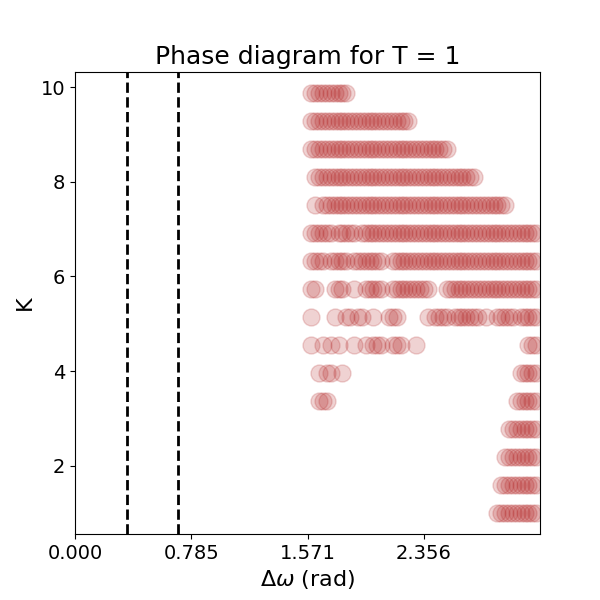

In [28]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('Phase diagram for T = ' + str(T), fontsize=18)
ax.set_ylabel('K', fontsize=16)
# set x label as delta omega using latex 
ax.set_xlabel(r'$\Delta \omega$ (rad)', fontsize=16)
# ax.set_ylim(0, 10)
ax.set_xlim(0, np.pi)
# ax.scatter(comp['omega_diff'], comp['T'], s=150, alpha=0.2, c='firebrick')
# ax.scatter(dec['omega_diff'], dec['T'], s=150, alpha=0.2, c='teal')
ax.scatter(comp['omega_diff'], comp['J12']/comp['J1'], s=150, alpha=0.2, c='firebrick')
ax.scatter(dec['omega_diff'], dec['J12']/dec['J1'], s=150, alpha=0.2, c='teal')
# increase the tick size and the label size
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xticks(np.arange(0, np.pi, np.pi/4))
# add vertical line at theta0
ax.axvline(x=theta0, color='black', linestyle='--', linewidth=2)
ax.axvline(x=2*theta0, color='black', linestyle='--', linewidth=2)
# save the figure in pdf 300 dpi
# plt.savefig('stica2.pdf', dpi=100, bbox_inches='tight')
plt.show()

In [122]:
# create a data frame with the results
df_comp = pd.DataFrame(columns=['J12', 'J1', 'J2', 'T', 'om', 'theta0', 'phi'])
df_dec = pd.DataFrame(columns=['J12', 'J1', 'J2', 'T', 'om', 'theta0', 'phi'])

# solve the equation for different values of J12, Jmax and T

theta0 = np.radians(20)

# T = 1
Jmax = 10
om2 = 0

for om1 in np.arange(0, np.pi/2, np.pi/100):
    for T in np.linspace(1, 300, 150):
        phi_i = [om1, om2]
        om = [om1, om2]
        phi_comp = fsolve(DiffE_phi_uvec_var, phi_i, args=(om, T, Jmax, Jmax))
        phi_dec = fsolve(DiffE_phi_uvec_var, phi_i, args=(om, T, Jmax, 0))

        # store the results in the data frame
        df_comp = df_comp.append({'J12': J12, 'J1': Jmax, 'J2': Jmax, 'T': T, 'om': om, 'theta0': theta0, 'phi': phi_comp}, ignore_index=True)
        df_dec = df_dec.append({'J12': J12, 'J1': Jmax, 'J2': 0, 'T': T, 'om': om, 'theta0': theta0, 'phi': phi_dec}, ignore_index=True)


In [123]:
# add a row with the check of the constraint
df_comp['is_sol'] = df_comp.apply(lambda row: check_constraint_comp(row['phi'], row['om'], row['theta0']), axis=1)
df_dec['is_sol'] = df_dec.apply(lambda row: check_constraint_dec(row['phi'], row['om'], row['theta0']), axis=1)

df_comp['is_stable'] = df_comp.apply(lambda row: is_stable(row['phi'], row['om'], row['T'], row['J12'], row['J1'], row['J2']), axis=1)
df_dec['is_stable'] = df_dec.apply(lambda row: is_stable(row['phi'], row['om'], row['T'], row['J12'], row['J1'], row['J2']), axis=1)

# add column omega_diff
df_comp['omega_diff'] = df_comp.apply(lambda row: row['om'][0] - row['om'][1], axis=1)
df_dec['omega_diff'] = df_dec.apply(lambda row: row['om'][0] - row['om'][1], axis=1)

In [124]:
comp = df_comp[(df_comp['is_sol'] == True) & (df_comp['is_stable'] == True)]
dec = df_dec[(df_dec['is_sol'] == True) & (df_dec['is_stable'] == True)]

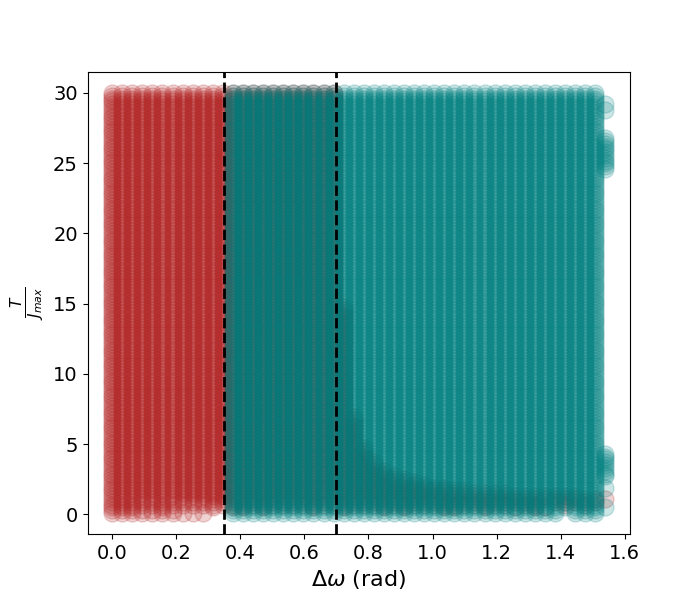

In [126]:
fig, ax = plt.subplots(figsize=(7, 6))
# ax.set_title('Phase diagram for T = ' + str(T), fontsize=18)
ax.set_ylabel(r'$\frac{T}{J_{max}}$', fontsize=16)
# set x label as delta omega using latex 
ax.set_xlabel(r'$\Delta \omega$ (rad)', fontsize=16)
# ax.set_ylim(0, 10)
# ax.set_xlim(0, np.pi)
# ax.scatter(comp['omega_diff'], comp['T'], s=150, alpha=0.2, c='firebrick')
# ax.scatter(dec['omega_diff'], dec['T'], s=150, alpha=0.2, c='teal')
ax.scatter(comp['omega_diff'], comp['T']/Jmax, s=150, alpha=0.2, c='firebrick')
ax.scatter(dec['omega_diff'], dec['T']/Jmax, s=150, alpha=0.2, c='teal')
# increase the tick size and the label size
ax.tick_params(axis='both', which='major', labelsize=14)
# ax.set_xticks(np.arange(0, np.pi, np.pi/4))
# add vertical line at theta0
ax.axvline(x=theta0, color='black', linestyle='--', linewidth=2)
ax.axvline(x=2*theta0, color='black', linestyle='--', linewidth=2)
# save the figure in pdf 300 dpi
# plt.savefig('stica2.pdf', dpi=100, bbox_inches='tight')
plt.show()